In [4]:
import healpy as hp
import numpy as np
import pylab as pl
import camb 
rot = hp.Rotator(coord=['C','G'])
from astropy.coordinates import SkyCoord
from astropy.io import fits
import pymaster as nmt
import sys
from scipy import stats
import copy
sys.path.append('/Users/gfabbian/Software/PolSpice_v03-07-05/bin')
rot = hp.Rotator(coord=['C','G'])

# Preparing data

### Resolution

Define resolution parameter for projections etc.

In [5]:
nside=256
beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)

### Masks
Reads and rotate QSO masks, selection function in galactic coordinates. Read Planck masks

In [6]:
binmask_c = hp.read_map('../../mask_qso_binary_mcs_dust_Av0.2_NSIDE256.fits')
mask_c = hp.read_map('../../mask_qso_prob_NSIDE256.fits')
mask = rot.rotate_map_pixel(mask_c)
binmask = rot.rotate_map_pixel(binmask_c)

# define selection function mask
inv_mask_c = 1/mask_c
inv_mask_c[mask_c==0]= 0.
inv_mask_g = rot.rotate_map_pixel(inv_mask_c)
inv_mask_g[inv_mask_g<1e-05] = 0

/var/folders/3c/k4c228y17_b7sq_m4m7gy8w80000gq/T/ipykernel_8868/569883139.py:7: RuntimeWarning: divide by zero encountered in divide
  inv_mask_c = 1/mask_c


In [7]:
# read files
try:
    lensmask = hp.read_map('/Users/fabbian/Work/Planck/DR3/COM_Lensing-CIBcomb_2000_R3.00/inputs/mask.fits')
    galmask40 = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=1)
    galmask = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=2)    
    galmask70 = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=3)        
except:
    lensmask = hp.read_map('/Users/gfabbian/Work/PR4_variations/mask.fits')
    galmask40 = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=1)
    galmask = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=2)  
    galmask70 = hp.read_map('/Users/gfabbian/Work/quasar_gaia/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=3)      
     


In [8]:
# degrade masks 
lensmask_lr = hp.ud_grade(lensmask,nside_out=nside)
lensmask_lr[lensmask_lr!=0]=1.

galmask70_lr = hp.ud_grade(galmask70,nside_out=nside)
galmask70_lr[galmask70_lr!=0]=1.

galmask_lr = hp.ud_grade(galmask,nside_out=nside)
galmask_lr[galmask_lr!=0]=1.

galmask40_lr = hp.ud_grade(galmask40,nside_out=nside)
galmask40_lr[galmask40_lr!=0]=1.


# create fsky 50% mask
testmask = nmt.mask_apodization(galmask_lr,15, apotype="C1")
galmask50_lr = np.array(testmask)
#threshold= 0.5 #for apo 10
threshold= 0.3
galmask50_lr[testmask<threshold]=0.
galmask50_lr[testmask>threshold]=1

binmask[binmask!=0]=1

### Lensing

Read data and filter maps to match $\ell_{max}$ set by nside parameter of HEALPIX grid

In [9]:
# compute delta  and k

klm = hp.read_alm('../../dat_klm.fits')
klm = hp.read_alm('/Users/gfabbian/Work/PR4_variations/PR42018like_klm_dat_MV.fits') # read DR4 instead of DR3
fl=np.ones(4097)
fl[3*nside-1:]=0.
khr=hp.alm2map(hp.almxfl(klm,fl),nside=2048,pol=False)

### QSO

Read catalog , convert position to galactic coordinates. 

In [120]:
# Prepare raw GAIA data
print("Read catalog and convert coordinate")
d=fits.open('../../gaia_G20.0.fits')
nqso = len(d[1].data['redshift_spz'])
print ("N_QSO in catalog",nqso)

sc = SkyCoord(ra=d[1].data["ra"], dec=d[1].data["dec"], unit='deg', frame='icrs', equinox='J2000.0')
gs = sc.transform_to(frame='galactic')

l_hp,b_hp = rot(d[1].data['ra'],d[1].data['dec'],lonlat=True)
l_hp[l_hp<0] = 360+l_hp[l_hp<0]
print("Galactic coordinate conversion astropy vs catalog rms delta_l %.4farcsec rms delta_b %.4farcsec"%(np.std(
    gs.l.value-d[1].data['l'])*3600,np.std(gs.b.value-d[1].data['b'])*3600))
print("Galactic coordinate conversion healpy  vs catalog rms delta_l %.4farcsec rms delta_b %.4farcsec"%(np.std(
    l_hp-d[1].data['l'])*3600,np.std(b_hp-d[1].data['b'])*3600))

Read catalog and convert coordinate
N_QSO in catalog 648842
Galactic coordinate conversion astropy vs catalog rms delta_l 0.0316arcsec rms delta_b 0.0076arcsec
Galactic coordinate conversion healpy  vs catalog rms delta_l 0.0221arcsec rms delta_b 0.0041arcsec


Project galaxy on sky and compute counts in pixels. 
then compute the density contrast using the mean of object computed over the footprint.  Then corrects counts by the selection function multiplying by the inverse probability before computing the overdensity.

Finally define splits for computing jackknife.

In [121]:
def make_counts(nside,l,b):
    counts=np.zeros(hp.nside2npix(nside))
    pix = hp.ang2pix(nside,l,b,lonlat=True)
    for p in pix:
        counts[p]+=1    
    return counts
split_reshuffle = np.arange(nqso)
np.random.shuffle(split_reshuffle)
m=make_counts(nside,gs.l.value,gs.b.value)
m1=make_counts(nside,(gs.l.value[split_reshuffle])[0::2],(gs.b.value[split_reshuffle])[0::2])
m2=make_counts(nside,(gs.l.value[split_reshuffle])[1::2],(gs.b.value[split_reshuffle])[1::2])

# the survey above is for ~50% of the sky. 
# compute correction of counts by probability density. 
msel=np.zeros(hp.nside2npix(nside))
msel[binmask!=0] = m[binmask!=0]*inv_mask_g[binmask!=0]

In [55]:
nbar_sel = np.mean(msel[binmask!=0])

nbar_full = np.mean(m[m!=0])
nbar_full_fsky50 = np.mean(m[galmask50_lr!=0])

nbar_full_sel = np.mean(msel[m!=0])

nbar = np.mean(m[binmask!=0])

# the line below uses the expected mean accounting for the selection function BUT does not correct the modulation itself
c = m/nbar -1
csel = msel/nbar_sel -1

nbar1 = np.mean(m1[binmask!=0])
c1 = m1/nbar1 -1

nbar2 = np.mean(m2[binmask!=0])
c2 = m2/nbar2 -1

jk =(c2-c1)/2
print("Counts Stats on Kate's mask")
print("nbar        ",nbar,"mean/std counts map",np.mean(m),np.std(m))
print("nbar selfun.",nbar_sel,"mean/std counts map",np.mean(msel),np.std(msel))
print("nbar1       ",nbar1,"mean/std counts map",np.mean(m1),np.std(m1))
print("nbar2       ",nbar2,"mean/std counts map",np.mean(m2),np.std(m2))
print()
print("Counts Stats on sky counts !=0")
print("nbar        ",nbar_full)
print("nbar fsky=50",nbar_full_fsky50)
print("nbar selfun.",nbar_full_sel)
print()
print("overdensity Stats on Kate's mask")
print("w/o selfunc.","mean/std counts map",np.mean(c[binmask!=0]),np.std(c[binmask!=0]))
print("w/  selfunc.","mean/std counts map",np.mean(csel[binmask!=0]),np.std(csel[binmask!=0]))
print("split 1       ","mean/std counts map",np.mean(c1[binmask!=0]),np.std(c1[binmask!=0]))
print("split 2       ","mean/std counts map",np.mean(c2[binmask!=0]),np.std(c2[binmask!=0]))
print("JK       ","mean/std counts map",np.mean(jk[binmask!=0]),np.std(jk[binmask!=0]))
print()
print("counts correction on Kate's mask w/ sel function.",np.sum(msel)/np.sum(m[binmask!=0]))

Counts Stats on Kate's mask
nbar         1.2225455565615475 mean/std counts map 0.8250452677408854 1.0337500142615053
nbar selfun. 1.243099102737518 mean/std counts map 0.6197776065672138 1.0365438031703522
nbar1        0.6111631109807573 mean/std counts map 0.4125226338704427 0.6887620793506953
nbar2        0.6113824455807904 mean/std counts map 0.4125226338704427 0.6873705142964381

Counts Stats on sky counts !=0
nbar         1.6440989334826643
nbar fsky=50 1.2208661305813255
nbar selfun. 1.235054295558502

overdensity Stats on Kate's mask
w/o selfunc. mean/std counts map 1.2583707410495252e-16 0.9154392390869722
w/  selfunc. mean/std counts map -2.1166143801063442e-17 0.9450519967581733
split 1        mean/std counts map -1.0699050770674534e-16 1.2882680323104787
split 2        mean/std counts map 3.131429493855961e-17 1.2850182487869042
JK        mean/std counts map 9.470399615099105e-17 0.9041147532716564

counts correction on Kate's mask w/ sel function. 1.0168120902044566


In [56]:
len(split_reshuffle)

648842

### Plotting

Displays data, footprint and redshift properties of catalog

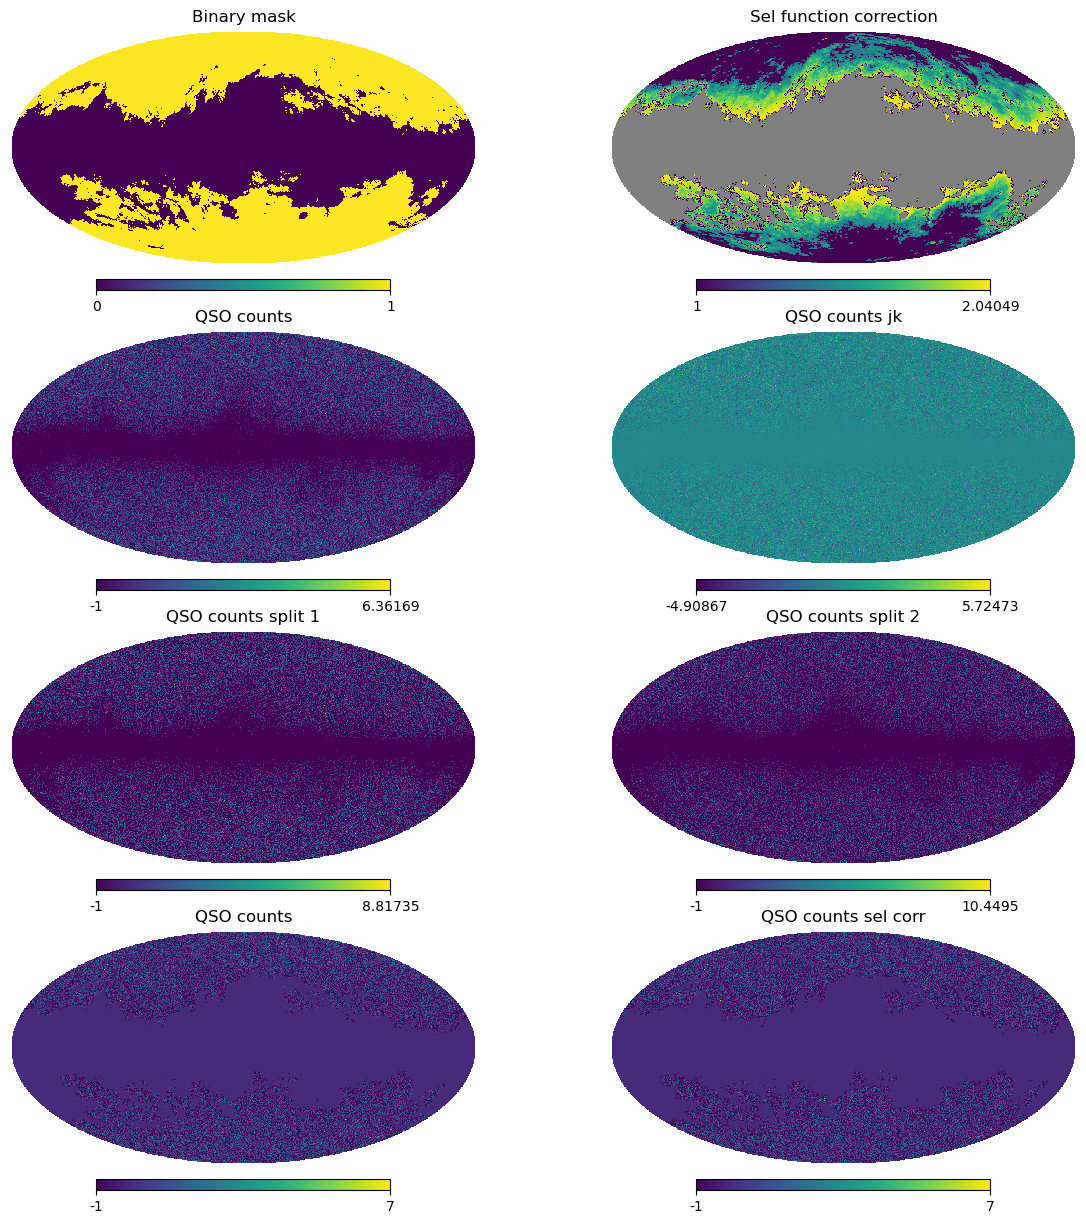

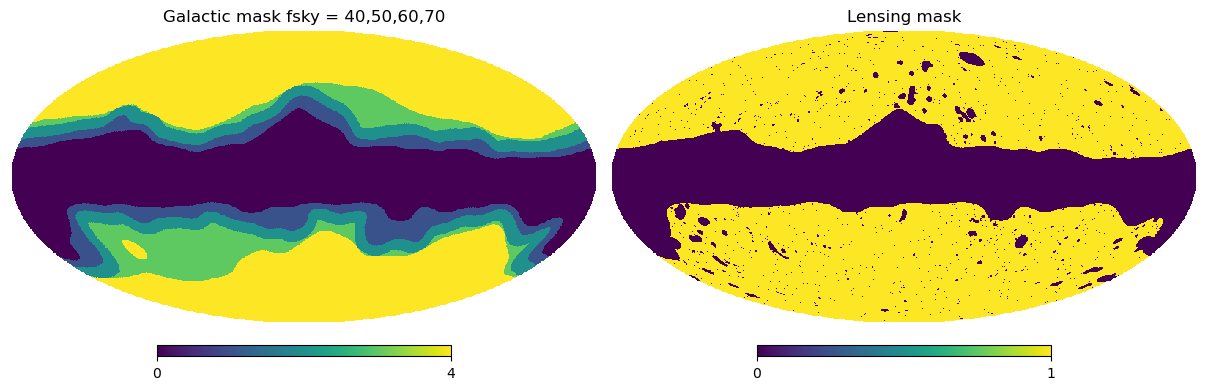

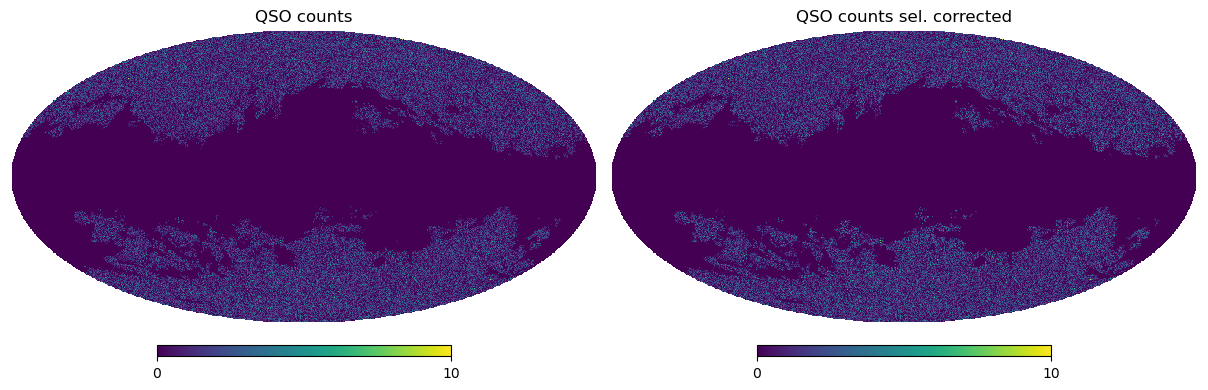

In [57]:
inv_mask_g_plot = np.array(inv_mask_g)
inv_mask_g_plot[inv_mask_g_plot==0]=hp.UNSEEN
pl.figure(figsize=(12,12))
hp.mollview(binmask,sub=421,title='Binary mask')
hp.mollview(inv_mask_g_plot,sub=422,title='Sel function correction',min=1,norm='hist')
hp.mollview(c,sub=423,title='QSO counts')
hp.mollview(jk,sub=424,title='QSO counts jk')
hp.mollview(c1,sub=425,title='QSO counts split 1')
hp.mollview(c2,sub=426,title='QSO counts split 2')
hp.mollview(c*binmask,sub=427,title='QSO counts',min=-1,max=7)
hp.mollview(csel*binmask,sub=428,title='QSO counts sel corr',min=-1,max=7)
pl.show()


pl.figure(figsize=(12,4))
hp.mollview(galmask_lr+galmask70_lr+galmask40_lr+galmask50_lr,sub=121,title='Galactic mask fsky = 40,50,60,70')
hp.mollview(lensmask,sub=122,title='Lensing mask')
pl.show()


pl.figure(figsize=(12,4))
hp.mollview(m*binmask,sub=121,title='QSO counts',max=10)
hp.mollview(msel*binmask,sub=122,title='QSO counts sel. corrected',max=10)
pl.show()

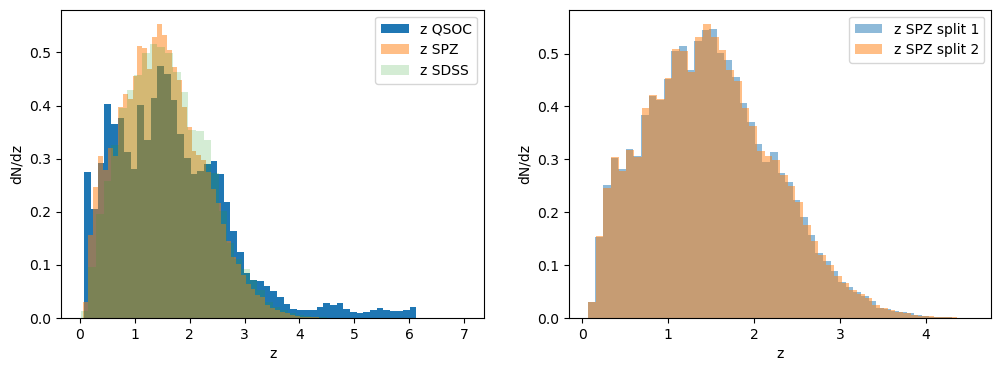

In [58]:
pl.figure(figsize=(12,4))
pl.subplot(1,2,1)
dndz_qsoc= pl.hist(d[1].data['redshift_qsoc'],bins=50,density=True,label='z QSOC')
dndz_spz= pl.hist(d[1].data['redshift_spz'],bins=50,density=True,alpha=0.5,label='z SPZ')
dndz_sdss= pl.hist(d[1].data['redshift_sdss'],bins=50,density=True,alpha=0.2,label='z SDSS')
pl.legend()
pl.xlabel('z')
pl.ylabel('dN/dz')
pl.subplot(1,2,2)
pl.hist(d[1].data['redshift_spz'][0::2],bins=50,density=True,alpha=0.5,label='z SPZ split 1')
pl.hist(d[1].data['redshift_spz'][1::2],bins=50,density=True,alpha=0.5,label='z SPZ split 2')
pl.xlabel('z')
pl.ylabel('dN/dz')
pl.legend()
pl.show()

# Theory model

Use $dN/dz$ to compute theory model using CAMB. Bias adopted from https://arxiv.org/pdf/1705.04718.pdf . In this model the median redshift of our sample should give a bias of around $b=2.45$

In [122]:
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow


def init_pars(do_magnification_bias=False):

    pars = camb.CAMBparams()
    lmax=1000
    
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0)
    pars.InitPower.set_params(As=2e-9, ns=0.965)
    pars.set_for_lmax(lmax, lens_potential_accuracy=4)
    ##set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = True
    
    ##NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both
    
    #density only is the default
    pars.SourceTerms.limber_windows = True
    pars.SourceTerms.limber_phi_lmin = 300
    pars.SourceTerms.counts_lensing = do_magnification_bias  
    pars.SourceTerms.counts_density  = True
    pars.SourceTerms.counts_redshift = True #weird problems at times
    pars.SourceTerms.counts_radial   = True # negligible at l<10
    pars.SourceTerms.counts_timedelay = True # negligible
    pars.SourceTerms.counts_ISW = True #negligible
    pars.SourceTerms.counts_velocity = True #negligible
    pars.SourceTerms.counts_potential = True #negligible
    pars.SourceTerms.counts_evolve = True # not sure what this is
    
    pars.Accuracy.LensingBoost = 1.0
    pars.Accuracy.NonlinSourceBoost = 1.0
    pars.Accuracy.BesselBoost = 1.0
    pars.Accuracy.LimberBoost = 1.0
    pars.Accuracy.SourceLimberBoost = 1.0
    return pars 

pars = init_pars()
dndz= pl.hist(d[1].data['redshift_spz'],bins=50)
pl.close()
#dndz= pl.hist(d[1].data['redshift_qsoc'],bins=50)
dndz=[np.diff(dndz[1])+dndz[1][:-1],dndz[0]]

# read dn/dz and normalize it
dndz[1]/=np.trapz(dndz[1],dndz[0])
#pl.plot(dndz[0],dndz[1])

##Set up W(z) window functions, later labelled W1 from Gaia dN/dz function.
b_quasar=2#2.35
W=np.array(dndz[1])
z=np.array(dndz[0])
pars.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z)), z=z, W=W,source_type='counts',dlog10Ndm = 0.0)]

results = camb.get_results(pars)

# In the returned dictionary P is the lensing potential and not deflection as in camb doc if raw_cl=True. 
# potentially related to CAMB version and fixed in later ones?
cmb = results.get_cmb_power_spectra(raw_cl=True,CMB_unit='muK')
cls = results.get_source_cls_dict(raw_cl=True) 

    

/var/folders/3c/k4c228y17_b7sq_m4m7gy8w80000gq/T/ipykernel_8868/1893565244.py:4: RuntimeWarning: divide by zero encountered in divide
  d2p=1/p2d
/var/folders/3c/k4c228y17_b7sq_m4m7gy8w80000gq/T/ipykernel_8868/1893565244.py:21: RuntimeWarning: invalid value encountered in divide
  rho = cls['PxW1']*p2k/np.sqrt(np.abs(cls['PxP']*(p2k**2)*cls['W1xW1']))


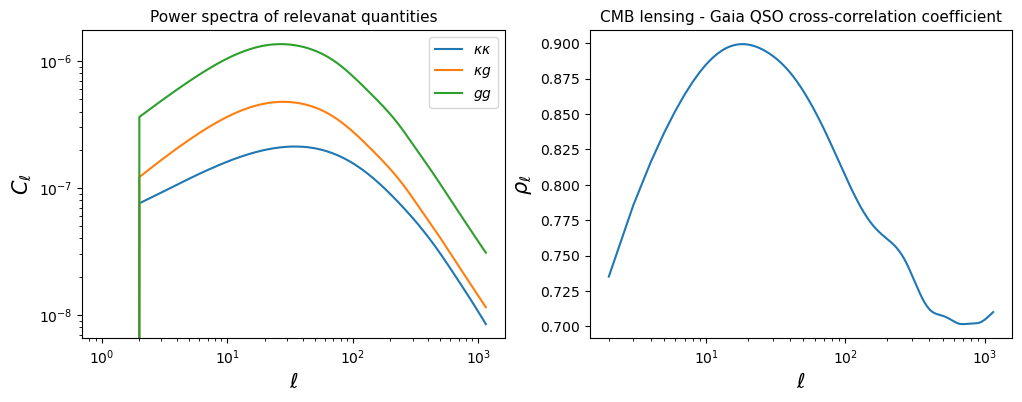

In [123]:
# plots power spectra
ls = np.arange(len(cls['PxP']))
p2d=np.sqrt(ls*(ls+1))
d2p=1/p2d
d2p[0:2]=0.0
d2k=p2d/2
p2k=(p2d**2/2)

pl.figure(figsize=(12,4))
pl.subplot(1,2,1)
pl.loglog(ls,cls['PxP']*p2k**2,label='$\kappa\kappa$')
pl.loglog(ls,cls['PxW1']*p2k,label='$\kappa g$') # should give kappaX for cross correlation
pl.loglog(ls,cls['W1xW1'],label='$gg$') 
pl.xlabel("$\ell$",size=15)
pl.ylabel("$C_\ell$",size=15)
pl.title("Power spectra of relevanat quantities",size=11)
pl.legend()


# compute correlation coefficient
rho = cls['PxW1']*p2k/np.sqrt(np.abs(cls['PxP']*(p2k**2)*cls['W1xW1']))
pl.subplot(1,2,2)
pl.semilogx(ls,np.abs(rho))
pl.xlabel("$\ell$",size=15)
pl.ylabel("$\\rho_\ell$",size=15)
pl.title("CMB lensing - Gaia QSO cross-correlation coefficient",size=11)
pl.show()

# Power spectrum estimation NAMASTER

### Data preparation
Define low resolution masks, apodizes them, downgrade lensing map to match QSO map. 

In [124]:
#khr_cl = hp.anafast(khr,lmax=4096,iter=1,pol=False)
apomask = nmt.mask_apodization(binmask,0.5, apotype="C2")
apomask_gal = nmt.mask_apodization(galmask_lr,1, apotype="C2")
apomask_gal40 = nmt.mask_apodization(galmask40_lr,1, apotype="C2")
apomask_gal50 = nmt.mask_apodization(galmask50_lr,2, apotype="C2")


# add point source masks
ps_mask = 1#lensmask_lr
apomask_lens = nmt.mask_apodization(binmask*ps_mask,0.5, apotype="C2")
apomask_gal_lens = nmt.mask_apodization(galmask_lr*ps_mask,1, apotype="C2")
apomask_gal40_lens = nmt.mask_apodization(galmask40_lr*ps_mask,1, apotype="C2")
apomask_gal50_lens = nmt.mask_apodization(galmask50_lr*ps_mask,2, apotype="C2")

klr = hp.ud_grade(khr,nside_out=nside)


Define binning, pseudo-power specturmc omputation function and function to compute all relevant quantities for a given mask and binning scheme

In [188]:
delta_b=20
ivar_weighting_binning=True
if ivar_weighting_binning:

    ells = np.arange(3 * nside, dtype='int32')
    weights = 2*ells+1.

    bpws = -1 + np.zeros_like(ells)  # Array of bandpower indices
    i = 0
    while delta_b * (i + 1) + 2 < 3 * nside:
        bpws[delta_b * i + 2:delta_b * (i + 1) + 2] = i
        i += 1

    b = nmt.NmtBin(nside=nside, bpws=bpws, ells=ells, weights=weights)
else:
    b = nmt.NmtBin.from_nside_linear(nside, delta_b,is_Dell=False)
    
lb = b.get_effective_ells()

def compute_master(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

def compute_master_crosscorr_mask(apodized_mask,binning):
    # corrects for pixel window function
    beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)
    
    f0 = nmt.NmtField(apodized_mask, [klr],beam=beam) # corrects for pixel window as klr computed from downgrade

    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f0, f0, binning)    

    f1 = nmt.NmtField( apodized_mask, [c-c[apodized_mask!=0].mean()],beam=beam)
    f11 = nmt.NmtField(apodized_mask, [c1],beam=beam)
    f12 = nmt.NmtField(apodized_mask, [c2],beam=beam)
    fjk = nmt.NmtField(apodized_mask, [jk],beam=beam)
    
    clkg = compute_master(f0, f1, w)[0]
    clgg = compute_master(f1, f1, w)[0]
    clkk = compute_master(f0, f0, w)[0]
    
    clkg1 = compute_master(f0, f11, w)[0]
    clg1g1 = compute_master(f11, f11, w)[0]
    
    clkg2 = compute_master(f0, f12, w)[0]
    clg2g2 = compute_master(f12, f12, w)[0]
    
    
    clg1g2 = compute_master(f11, f12, w)[0]
    clkgjk = compute_master(f0, fjk, w)[0]
    clgjk = compute_master(fjk, fjk, w)[0]
    
    cl_gg_th_binned = w.decouple_cell(w.couple_cell([cls['W1xW1']]))[0]
    cl_kg_th_binned = w.decouple_cell(w.couple_cell([cls['PxW1']*p2k]))[0]
    cl_kk_th_binned = w.decouple_cell(w.couple_cell([hp.alm2cl(klm)]))[0]    
    return clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,cl_kk_th_binned


### Computation and plotting

In [126]:
analysis_mask = apomask_gal50 # avoids some of the auto correlation problem in bandpowers (more regular object)
clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,cl_kk_th_binned = compute_master_crosscorr_mask(analysis_mask,b)

In [127]:
def plot_summary(clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,cl_kk_th_binned,lb=lb,delta_b=delta_b,analysis_mask=analysis_mask,lmin=10):
    dkg = np.sqrt(clkk*clgg + clkg**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkg1 = np.sqrt(clkk*clg1g1 + clkg1**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkg2 = np.sqrt(clkk*clg2g2 + clkg2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkgjk = np.sqrt(clkk*clgjk)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    dkg_th = np.sqrt(cl_kk_th_binned*clgg + clkg**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    
    lbmin=0
    chi2=((clkg-cl_kg_th_binned)/dkg)[lbmin:]**2
    chi2null=(clkg/dkg)[lbmin:]**2
    chi2jk=(clkgjk/dkgjk)[lbmin:]**2
    dof = len(chi2) -1
    snr = np.sqrt(np.cumsum(chi2null)[-1])
    snrth = np.sqrt(np.cumsum(clkg**2/dkg_th**2)[-1]) # uses theory error bar and not data-based estimates
    significance = np.sqrt(np.sum(chi2null) - np.sum(chi2))
    print("lmin",lb[lbmin],"dof",dof,"chi2null/dof %.3f"%(np.sum(chi2null)/dof))
    print("kg snr %.3f"%snr,'snr [th errors] %.3f'%snrth)
    print("kg chi2/dof    %.3f"%(np.sum(chi2)/dof),'PTE',1 - stats.chi2.cdf(np.sum(chi2), dof))
    print("kg chi2/dof JK %.3f"%(np.sum(chi2jk)/dof),'PTE',1 - stats.chi2.cdf(np.sum(chi2jk), dof))
    print("significance [delta chi2] %.3f"%significance)
    
    pl.figure(figsize=(12,8))
    pl.subplot(2,2,1)
    pl.errorbar(lb,clkg,dkg,label='kg',marker='o')
    rescale = cl_kg_th_binned[1]/clkg[1]
    pl.errorbar(lb+6,clkgjk,dkgjk,label='kgjk bias',marker='x',ls='')
    #pl.errorbar(lb,clkg*rescale,dkg*rescale,label='kg bias rescaled',marker='o')
    pl.errorbar(lb,cl_kg_th_binned,label='th kg binned',color='black',ls='-')
    pl.errorbar(lb,clkk,label='kk')
    #pl.errorbar(lb,cl_kk_th_binned,label='th kk binned') # from input alms 
    pl.xscale("log")
    pl.yscale("log")
    pl.ylim(1e-08,5e-06)
    pl.xlim(lmin,1000)
    pl.legend(loc='best',ncol=2)
    #pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("Full catalog results")
    #pl.show()
    
    # QSO splits CROSS-CORRELATION w/ Lensing
    pl.subplot(2,2,2)
    rescale = cl_kg_th_binned[1]/clkg[1]
    pl.errorbar(lb,clkg1,dkg1,label='kg1 bias',marker='o',ls='')
    pl.errorbar(lb+2,clkg2,dkg2,label='kg2 bias',marker='o',ls='')
    #pl.errorbar(lb+6,clkgjk,dkgjk,label='kgjk bias',marker='o',ls='')
    #pl.errorbar(lb,clkg*rescale,dkg*rescale,label='kg bias rescaled',marker='o')
    pl.errorbar(lb,cl_kg_th_binned,label='th kg binned',color='black',ls='-')
    pl.xscale("log")
    pl.yscale("log")
    pl.ylim(1e-08,5e-06)
    pl.xlim(lmin,1000)
    pl.legend(loc='best',ncol=2)
    #pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("Catalog split results")
    
    # QSO JACKKNIFE CROSS-CORRELATION w/ Lensing
    pl.subplot(2,2,3)
    pl.errorbar(lb,clkgjk,dkgjk,label='kgjk ',marker='o',ls='')
    pl.axhline(0,color='black')
    pl.xlim(lmin,1000)
    pl.legend(loc='best',ncol=2)
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("QSO Jakknife")
    
             
    # GALAXY AUTO    
    shot_noise = (lb*hp.nside2resol(nside)**2*1/nbar/lb)/beam[lb.astype(np.int32)]**2
    shot_noise1 = lb*hp.nside2resol(nside)**2*1/nbar1/lb/beam[lb.astype(np.int32)]**2
    shot_noise2 = lb*hp.nside2resol(nside)**2*1/nbar2/lb/beam[lb.astype(np.int32)]**2
    
    pl.subplot(2,2,4)
    dgXg = np.sqrt(clg1g1*clg2g2 +clg1g2**2)/np.sqrt((2*lb+1)*delta_b*np.mean(analysis_mask))
    pl.errorbar(lb,clgg,label='gg')
    pl.errorbar(lb,clgg-clgjk,label='gg - gjk')
    pl.errorbar(lb,clg1g1,label='g1g1',ls='-')
    pl.errorbar(lb,clg2g2,label='g2g2',ls='--')
    pl.errorbar(lb,clg1g2,yerr=dgXg,label='g1g2',ls='--')
    pl.errorbar(lb,clgjk,label='gjk')
    #pl.errorbar(lb,shot_noise,color='black',label='gg shot noise',ls=':')
    pl.errorbar(lb,cl_gg_th_binned+shot_noise,color='black',label='gg th+shot noise',ls=':')
    #pl.errorbar(lb,cl_gg_th_binned+shot_noise1,color='green',label='gg th+shot noise',ls=':')
    #pl.errorbar(lb,cl_gg_th_binned+shot_noise2,color='red',label='gg th+shot noise',ls=':')
    pl.errorbar(lb,cl_gg_th_binned,label='th gg binned',color='black',ls='-.')
    #pl.errorbar(lb,(cl_gg_th_binned+clgjk),label='th gg binned +jk',color='black',ls='-.')
    pl.xscale("log")
    pl.yscale("log")
    pl.ylim(1e-08,6e-03)
    pl.xlim(lmin,1000)
    pl.legend(loc='best',ncol=2)
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C_\ell$',size=15)
    pl.title("QSO auto")
    pl.show()

lmin 14.270833333333332 dof 37 chi2null/dof 7.723
kg snr 16.904 snr [th errors] 20.214
kg chi2/dof    0.948 PTE 0.5600188231532791
kg chi2/dof JK 0.979 PTE 0.5047354984445309
significance [delta chi2] 15.833


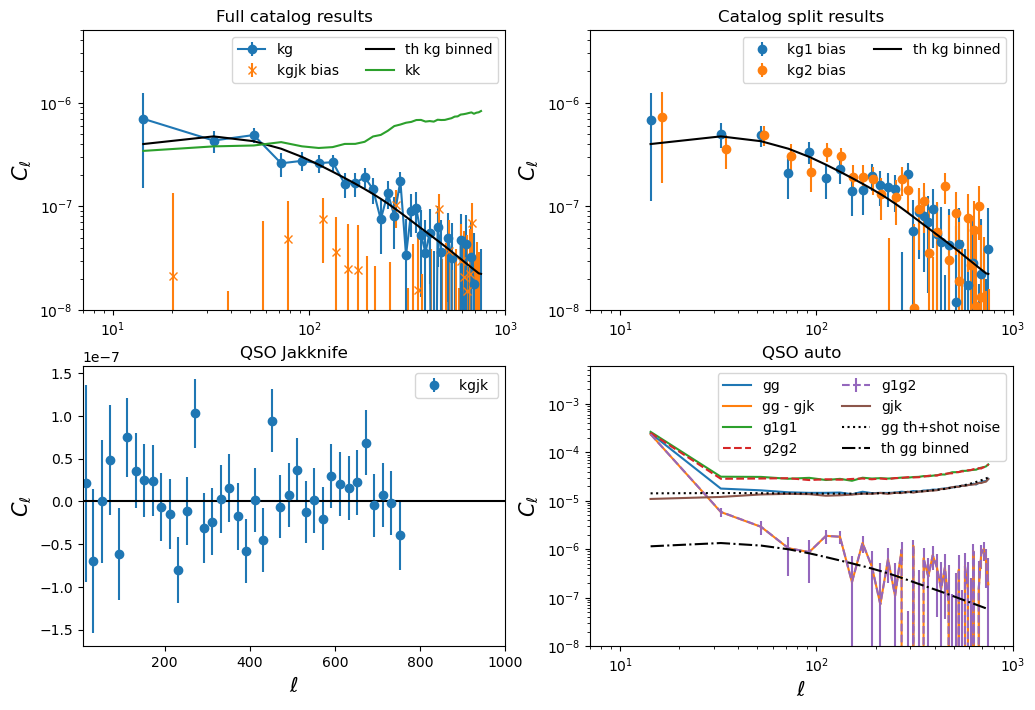

In [128]:
plot_summary(clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk,cl_gg_th_binned,cl_kg_th_binned,cl_kk_th_binned,lmin=7)


# Power spectrum estimation PolSPICE


In [129]:
import ispice
from bin_llcl import bin_llcl

### Computation 

write fits file to conform to python wrapper

In [130]:
# write maps for polspice
hp.write_map('../../klr.fits',klr,overwrite=True)
hp.write_map('../../g.fits',c,overwrite=True)
hp.write_map('../../gsel.fits',csel,overwrite=True)
hp.write_map('../../g1.fits',c1,overwrite=True)
hp.write_map('../../g2.fits',c2,overwrite=True)
hp.write_map('../../gjk.fits',jk,overwrite=True)
hp.write_map('../../analysis_mask.fits',analysis_mask,overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


Computes all auto and cross

In [131]:
# auto
ispice.ispice('../../klr.fits', '../../cl_klr.fits', covfileout='', mapfile2='', thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', weightfile2='',verbosity='NO')
ispice.ispice('../../g.fits', '../../cl_g.fits', covfileout='', mapfile2='', thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', weightfile2='',verbosity='NO')
ispice.ispice('../../g1.fits', '../../cl_g1.fits', covfileout='', mapfile2='', thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', weightfile2='',verbosity='NO')
ispice.ispice('../../g2.fits', '../../cl_g2.fits', covfileout='', mapfile2='', thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', weightfile2='',verbosity='NO')
ispice.ispice('../../gjk.fits', '../../cl_gjk.fits', covfileout='', mapfile2='', thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', weightfile2='',verbosity='NO')

Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_klr.fits -decouple NO -mapfile ../../klr.fits -fits_out YES -weightfile ../../analysis_mask.fits -nlmax -1 -normfac 1.0 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity NO -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 
 ===> HEALPIXDATA not defined, trying HEALPIX...
 ===> Using HEALPIXDATA=/Users/gfabbian/Software/Healpix_3.82/data/
 CPU  Time [s]:   0.374770999    
 Wall Time [s]:   0.125000000    
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO

Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_g.fits -decouple NO -mapfile ../../g.fits -fits_out YES -weightfile ../../analysis_mask.fit

0

In [132]:
# cross

ispice.ispice('../../klr.fits', '../../cl_kg.fits', covfileout='', mapfile2='../../g.fits', 
              thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', 
              weightfile2='../../analysis_mask.fits',verbosity='NO')
ispice.ispice('../../klr.fits', '../../cl_kg1.fits', covfileout='', mapfile2='../../g1.fits', 
              thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', 
              weightfile2='../../analysis_mask.fits',verbosity='NO')
ispice.ispice('../../klr.fits', '../../cl_kg2.fits', covfileout='', mapfile2='../../g2.fits', 
              thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', 
              weightfile2='../../analysis_mask.fits',verbosity='NO')
ispice.ispice('../../klr.fits', '../../cl_kgjk.fits', covfileout='', mapfile2='../../gjk.fits', 
              thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', 
              weightfile2='../../analysis_mask.fits',verbosity='NO')
ispice.ispice('../../g1.fits', '../../cl_g1g2.fits', covfileout='', mapfile2='../../g2.fits', 
              thetamax='NO', tolerance='NO', weightfile1='../../analysis_mask.fits', 
              weightfile2='../../analysis_mask.fits',verbosity='NO')

Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_kg.fits -decouple NO -mapfile ../../klr.fits -mapfile2 ../../g.fits -fits_out YES -weightfile ../../analysis_mask.fits -weightfile2 ../../analysis_mask.fits -nlmax -1 -normfac 1.0 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity NO -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 
 ===> HEALPIXDATA not defined, trying HEALPIX...
 ===> Using HEALPIXDATA=/Users/gfabbian/Software/Healpix_3.82/data/
 CPU  Time [s]:   0.729016006    
 Wall Time [s]:   0.187500000    
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO

Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_kg1.fits -decouple NO -mapfile 

0

Bins the $C_\ell$s using the same binning. We assumed uniform binning to conform with what we did in NAMASTER. 

In [133]:
b_spice=np.arange(2,3*nside-1,20)
do_uniform = True
lb_spice,clkk_spice,dl,buf=bin_llcl(hp.read_cl('../../cl_klr.fits'),b_spice,uniform=do_uniform)
clgg_spice=bin_llcl(hp.read_cl('../../cl_g.fits'),b_spice,uniform=do_uniform)[1]
clg1g1_spice=bin_llcl(hp.read_cl('../../cl_g1.fits'),b_spice,uniform=do_uniform)[1]
clg2g2_spice=bin_llcl(hp.read_cl('../../cl_g2.fits'),b_spice,uniform=do_uniform)[1]
clgjk_spice=bin_llcl(hp.read_cl('../../cl_gjk.fits'),b_spice,uniform=do_uniform)[1]

clkg_spice=bin_llcl(hp.read_cl('../../cl_kg.fits'),b_spice,uniform=do_uniform)[1]
clkg1_spice=bin_llcl(hp.read_cl('../../cl_kg1.fits'),b_spice,uniform=do_uniform)[1]
clkg2_spice=bin_llcl(hp.read_cl('../../cl_kg2.fits'),b_spice,uniform=do_uniform)[1]
clkgjk_spice=bin_llcl(hp.read_cl('../../cl_kgjk.fits'),b_spice,uniform=do_uniform)[1]
clkg2_spice=bin_llcl(hp.read_cl('../../cl_kg2.fits'),b_spice,uniform=do_uniform)[1]

clg1g2_spice=bin_llcl(hp.read_cl('../../cl_g1g2.fits'),b_spice,uniform=do_uniform)[1]

clkk_spice_ivar=bin_llcl(hp.read_cl('../../cl_klr.fits'),b_spice,uniform=False)[1]
clkg_spice_ivar=bin_llcl(hp.read_cl('../../cl_kg.fits'),b_spice,uniform=False)[1]
clgg_spice_ivar=bin_llcl(hp.read_cl('../../cl_g.fits'),b_spice,uniform=False)[1]
clg1g2_spice_ivar=bin_llcl(hp.read_cl('../../cl_g1g2.fits'),b_spice,uniform=False)[1]

cl_gg_th_binned_spice=bin_llcl(cls['W1xW1'],b_spice,uniform=do_uniform)[1]
cl_kg_th_binned_spice=bin_llcl(cls['PxW1']*p2k,b_spice,uniform=do_uniform)[1]
cl_kk_th_binned_spice=bin_llcl(hp.alm2cl(klm),b_spice,uniform=do_uniform)[1]

lmin 11.5 dof 37 chi2null/dof 7.689
kg snr 16.867 snr [th errors] 20.183
kg chi2/dof    0.946 PTE 0.5626503072943188
kg chi2/dof JK 0.889 PTE 0.6622712871702591
significance [delta chi2] 15.795


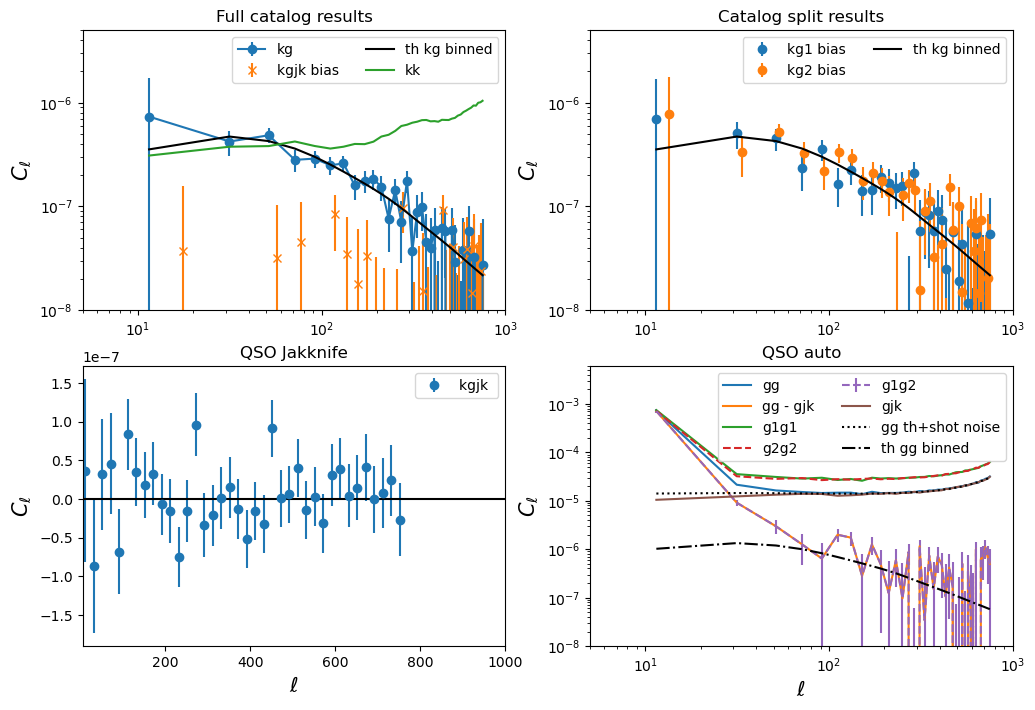

In [134]:
plot_summary(clkg_spice,clgg_spice,clkk_spice,clkg1_spice,clg1g1_spice,clkg2_spice,clg2g2_spice,clg1g2_spice,
             clkgjk_spice,clgjk_spice,cl_gg_th_binned_spice,cl_kg_th_binned_spice,cl_kk_th_binned_spice,
             lb=lb_spice,delta_b=dl,lmin=5)

### Method comparison

For the cross-correlation, the points are essentially the same except for the first 1 or 2 bin if we do not adopt the same binning scheme (i.e. not weighting the multipoles by $(2\ell+1)$ (which is equivalent to an inverse variance weighting). Also note that the effective center of the bin changes if we adopt a flat binning or an inverse variance weighted binning so some of the shift of the curves is due to that.

The inverse variance weight lowers the value of the first bin and in particular in the galaxy auto spectrum things improve. We need to optimize the large scale estimation.

SPICE seems to handle better the largest scales when the mask is complicated (i.e. when using the native one). 

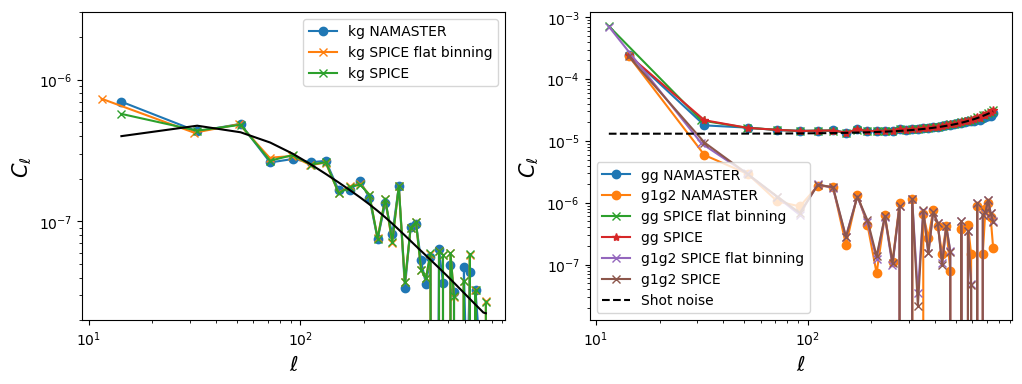

In [139]:
pl.figure(figsize=(12,4))

pl.subplot(1,2,1)
pl.errorbar(lb,clkg,marker='o',label='kg NAMASTER')
pl.errorbar(lb_spice,clkg_spice,marker='x',label='kg SPICE flat binning')
pl.errorbar(lb,clkg_spice_ivar,marker='x',label='kg SPICE')
pl.errorbar(lb,cl_kg_th_binned,color='black')
pl.xscale('log')
pl.yscale('log')
pl.ylim(2e-08,3e-06)
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.legend()
pl.subplot(1,2,2)
pl.errorbar(lb,clgg,marker='o',label='gg NAMASTER')
pl.errorbar(lb,clg1g2,marker='o',label='g1g2 NAMASTER')
pl.errorbar(lb_spice,clgg_spice,marker='x',label='gg SPICE flat binning')
pl.errorbar(lb,clgg_spice_ivar,marker='*',label='gg SPICE')
pl.errorbar(lb_spice,clg1g2_spice,marker='x',label='g1g2 SPICE flat binning')
pl.errorbar(lb,clg1g2_spice_ivar,marker='x',label='g1g2 SPICE ')
shot_noise = (lb_spice*hp.nside2resol(nside)**2*1/nbar/lb_spice)/beam[lb_spice.astype(np.int32)]**2
pl.errorbar(lb_spice,shot_noise,ls='--',color='black',label='Shot noise')
pl.xscale('log')
pl.yscale('log')
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.legend()
pl.show()

# Selection function  effects 

Stor map and recompute power spectra on a mask where the selection function correction is defined and the number counts have been corrected for that.

In [147]:
hp.write_map('../../apodized_mask_kate.fits',apomask,overwrite=True)

setting the output map dtype to [dtype('float64')]


In [142]:
f0 = nmt.NmtField(apomask, [klr],beam=beam) # corrects for pixel window as klr computed from downgrade

w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f0, f0, b)

fcsel = nmt.NmtField(apomask, [csel],beam=beam) # corrects for pixel window as klr computed from downgrade

fc = nmt.NmtField(apomask, [c],beam=beam) # corrects for pixel window as klr computed from downgrade
clkk_csel = compute_master(f0,f0,w)[0]
clkg_csel = compute_master(f0,fcsel,w)[0]
clgg_csel = compute_master(fcsel,fcsel,w)[0]
clkg_c = compute_master(f0,fc,w)[0]
clgg_c = compute_master(fc,fc,w)[0]

# do the cross with spice
ispice.ispice('../../klr.fits', '../../cl_klr_apomask.fits', weightfile1='../../apodized_mask_kate.fits',
              verbosity='NO')
ispice.ispice('../../gsel.fits', '../../cl_gsel_apomask.fits', weightfile1='../../apodized_mask_kate.fits',
              verbosity='NO')
ispice.ispice('../../klr.fits', '../../cl_kgsel_apomask.fits', covfileout='', mapfile2='../../gsel.fits', 
              weightfile1='../../apodized_mask_kate.fits', weightfile2='../../apodized_mask_kate.fits',
              verbosity='NO')
ispice.ispice('../../g.fits', '../../cl_g_apomask.fits', weightfile1='../../apodized_mask_kate.fits',
              verbosity='NO')
ispice.ispice('../../klr.fits', '../../cl_kg_apomask.fits', covfileout='', mapfile2='../../g.fits', 
              weightfile1='../../apodized_mask_kate.fits', weightfile2='../../apodized_mask_kate.fits',
              verbosity='NO')


b_spice=np.arange(2,3*nside-1,20)
do_uniform = False
lb_spice,clkk_spice_csel,dl,buf=bin_llcl(hp.read_cl('../../cl_klr_apomask.fits'),b_spice,uniform=do_uniform)
clgg_spice_csel=bin_llcl(hp.read_cl('../../cl_gsel_apomask.fits'),b_spice,uniform=do_uniform)[1]
clgg_spice_c=bin_llcl(hp.read_cl('../../cl_g_apomask.fits'),b_spice,uniform=do_uniform)[1]
clkg_spice_csel=bin_llcl(hp.read_cl('../../cl_kgsel_apomask.fits'),b_spice,uniform=do_uniform)[1]
clkg_spice_c=bin_llcl(hp.read_cl('../../cl_kg_apomask.fits'),b_spice,uniform=do_uniform)[1]


Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_klr_apomask.fits -decouple NO -mapfile ../../klr.fits -fits_out YES -weightfile ../../apodized_mask_kate.fits -nlmax -1 -normfac 1.0 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity NO -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 
 ===> HEALPIXDATA not defined, trying HEALPIX...
 ===> Using HEALPIXDATA=/Users/gfabbian/Software/Healpix_3.82/data/
 CPU  Time [s]:   0.323569000    
 Wall Time [s]:    9.37500000E-02
Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO

Submitting job 0
/Users/gfabbian/Software/PolSpice_v03-07-05/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile ../../cl_gsel_apomask.fits -decouple NO -mapfile ../../gsel.fits -fits_out YES -weightf

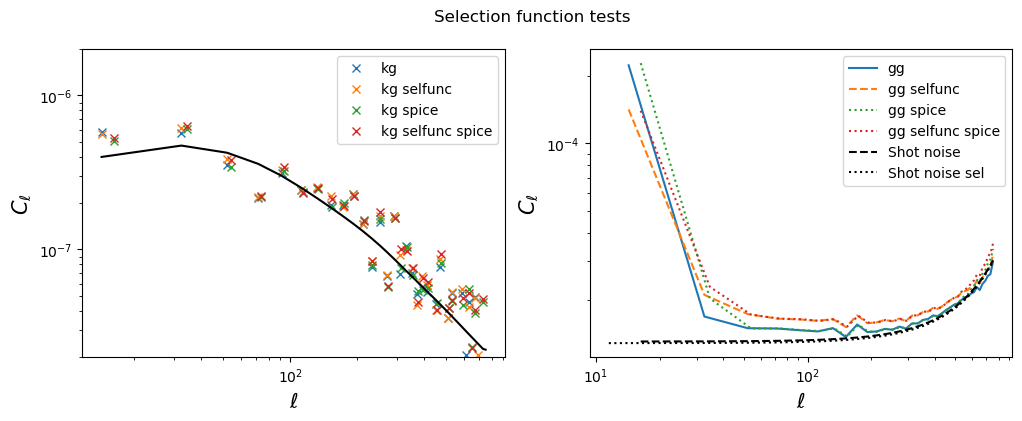

In [148]:
pl.figure(figsize=(12,4))
pl.subplot(121)
pl.loglog(lb,clkg_c,label='kg',ls='',marker='x')
pl.loglog(lb,clkg_csel,label='kg selfunc',ls='',marker='x')
pl.loglog(lb+2,clkg_spice_c,label='kg spice',ls='',marker='x')
pl.loglog(lb+2,clkg_spice_csel,label='kg selfunc spice',ls='',marker='x')
pl.loglog(lb,cl_kg_th_binned,color='black')
pl.ylim(2e-08,2e-06)
pl.legend()
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.subplot(122)
pl.loglog(lb,clgg_c,label='gg')
pl.loglog(lb,clgg_csel,label='gg selfunc',ls='--')
pl.loglog(lb+2,clgg_spice_c,label='gg spice',ls=':')
pl.loglog(lb+2,clgg_spice_csel,label='gg selfunc spice',ls=':')
pl.errorbar(lb+2,shot_noise,ls='--',color='black',label='Shot noise')

shot_noise_sel = (lb*hp.nside2resol(nside)**2*1/nbar_sel/lb)/beam[lb_spice.astype(np.int32)]**2
pl.errorbar(lb_spice,shot_noise_sel,ls=':',color='black',label='Shot noise sel')
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
pl.legend()
pl.suptitle("Selection function tests")
pl.show()

# Summary

We need to implement inverse variance weighting in the pseudo-$C_\ell$ as it seems to perform better for SPICE. The mask is somehow nasty and we need to introduce some tapering that is effective on both methods. We see oscillations of fractions of sigma at $\ell\gtrsim 50$. Small scales seem to be relatively under control but anything below 50 requires some attention.

The auto spectrum of QSO dominated by shot noise and and displays a big excess of power in the first 1 or 2 bins that we need to address. As it is so noise dominated is likely not having any constraining power though the cross-spectra analysis using data splits seems to be ok. The jackknife estimate of the noise and the cross-correlation from data split to compute the power spectrum of galaxies withouth noise bias needs to be refined. 


The behavior of the first 2 bin is somehow sensitive to the mask choice and power spectrum estimator. We might thus need to introduce some inverse variance weighting in the binning. 

# Tomography

We can repeat a similar analysis splitting the sample in 4 equally populated redshift bins. The splitting gives sub-samples with the following properties.

bounds tomographic bins [0, 0.9440646171569824, 1.447939, 1.974499, 4.54]
effective median redhisfts 0.6200702520427703 1.201 1.6849333047866821 2.383 2.88
effective mean redhisfts 0.59904534876775 1.2025720962418147 1.6933676386481 2.4737030208453596 2.9648669544340454


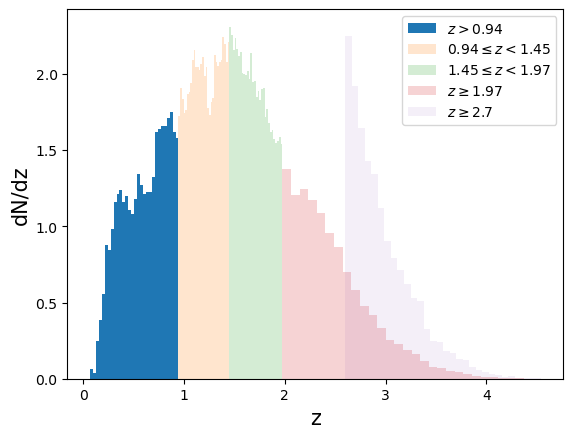

In [149]:
zcat=d[1].data['redshift_spz']
bounds = np.percentile(zcat,[25,50,75])
mask_z1 = zcat<bounds[0]
mask_z2 = (zcat>=bounds[0])&(zcat<bounds[1])
mask_z3 = (zcat>=bounds[1])&(zcat<bounds[2])
mask_z4 = zcat>=bounds[2]
mask_z5 = zcat>=2.6


#np.percentile(d[1].data['redshift_spz'],[33,66])
print("bounds tomographic bins",[0]+list(bounds)+[np.max(z)])
print("effective median redhisfts",np.median(zcat[mask_z1]),np.median(zcat[mask_z2]),np.median(zcat[mask_z3]),
      np.median(zcat[mask_z4]),np.median(zcat[mask_z5]))
print("effective mean redhisfts",np.mean(zcat[mask_z1]),np.mean(zcat[mask_z2]),np.mean(zcat[mask_z3]),
      np.mean(zcat[mask_z4]),np.mean(zcat[mask_z5]))

dndz1=pl.hist(zcat[mask_z1],bins=30,density=True,label=          '$z>%.2f$'%bounds[0])
dndz2=pl.hist(zcat[mask_z2],bins=30,density=True,alpha=0.2,label='$%.2f\leq z<%.2f$'%(bounds[0],bounds[1]))
dndz3=pl.hist(zcat[mask_z3],bins=30,density=True,alpha=0.2,label='$%.2f\leq z<%.2f$'%(bounds[1],bounds[2]))
dndz4=pl.hist(zcat[mask_z4],bins=30,density=True,alpha=0.2,label='$z\geq %.2f$'%bounds[-1])
dndz5=pl.hist(zcat[mask_z5],bins=30,density=True,alpha=0.1,label='$z\geq 2.7$')
pl.xlabel("z",size=15)
pl.ylabel("dN/dz",size=15)
pl.legend()
pl.show()

In [150]:
# compute dndz

dndz1=[np.diff(dndz1[1])/2+dndz1[1][:-1],dndz1[0]]
dndz2=[np.diff(dndz2[1])/2+dndz2[1][:-1],dndz2[0]]
dndz3=[np.diff(dndz3[1])/2+dndz3[1][:-1],dndz3[0]]
dndz4=[np.diff(dndz4[1])/2+dndz4[1][:-1],dndz4[0]]
dndz5=[np.diff(dndz5[1])/2+dndz5[1][:-1],dndz5[0]]
dndz1[1]/=np.trapz(dndz1[1],dndz1[0])
dndz2[1]/=np.trapz(dndz2[1],dndz2[0])
dndz3[1]/=np.trapz(dndz3[1],dndz3[0])
dndz4[1]/=np.trapz(dndz4[1],dndz4[0])
dndz5[1]/=np.trapz(dndz5[1],dndz5[0])


Using the $dN/dz$ of all the samples we compute the theory curves expected from the sample. We assume the same effective bias as for the full sample

In [151]:
##Set up W(z) window functions, later labelled W1 from Gaia dN/dz function.

pars1=init_pars()
W1=np.array(dndz1[1])
z1=np.array(dndz1[0])
pars1.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z1)), z=z1, W=W1,source_type='counts')]
results1 = camb.get_results(pars1)
cls1 = results1.get_source_cls_dict(raw_cl=True) 

pars2=init_pars()
W2=np.array(dndz2[1])
z2=np.array(dndz2[0])
pars2.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z2)), z=z2, W=W2,source_type='counts')]
results2= camb.get_results(pars2)
cls2 = results2.get_source_cls_dict(raw_cl=True) 

pars3=init_pars()
W3=np.array(dndz3[1])
z3=np.array(dndz3[0])
pars3.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z3)), z=z3, W=W3,source_type='counts')]
results3 = camb.get_results(pars3)
cls3 = results3.get_source_cls_dict(raw_cl=True) 

pars4=init_pars()
W4=np.array(dndz4[1])
z4=np.array(dndz4[0])
pars4.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z4)), z=z4, W=W4,source_type='counts')]
results4 = camb.get_results(pars4)
cls4 = results4.get_source_cls_dict(raw_cl=True) 

pars5=init_pars()
W5=np.array(dndz5[1])
z5=np.array(dndz5[0])
pars5.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z5)), z=z5, W=W4,source_type='counts')]
results5 = camb.get_results(pars5)
cls5 = results5.get_source_cls_dict(raw_cl=True) 



The maps are computed following the steps used for the full sample

In [277]:


mz1 = make_counts(nside,gs.l.value[mask_z1],gs.b.value[mask_z1])
mz2 = make_counts(nside,gs.l.value[mask_z2],gs.b.value[mask_z2])
mz3 = make_counts(nside,gs.l.value[mask_z3],gs.b.value[mask_z3])
mz4 = make_counts(nside,gs.l.value[mask_z4],gs.b.value[mask_z4])
mz5 = make_counts(nside,gs.l.value[mask_z5],gs.b.value[mask_z5])

nbar_z1 = np.mean(mz1[binmask!=0])
nbar_z2 = np.mean(mz2[binmask!=0])
nbar_z3 = np.mean(mz3[binmask!=0])
nbar_z4 = np.mean(mz4[binmask!=0])
nbar_z5 = np.mean(mz5[binmask!=0])

cz1 = mz1/nbar_z1- 1
cz2 = mz2/nbar_z2- 1
cz3 = mz3/nbar_z3- 1
cz4 = mz4/nbar_z4- 1
cz5 = mz5/nbar_z5- 1
print("nbar full",nbar)
print("nbar zbins",nbar_z1,nbar_z2,nbar_z3,nbar_z4)
print("nbar zbin high z",nbar_z5)


nbar full 1.2225455565615475
nbar zbins 0.29384970479093075 0.3041176245552736 0.306785345388235 0.31779288182710824
nbar zbin high z 0.09884084214284804


In [162]:
f0 = nmt.NmtField(apomask_gal50, [klr],beam=beam) # corrects for pixel window as klr computed from downgrade

w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f0, f0, b)

clkk_cz = compute_master(f0,f0,w)[0]
clkg_cz=[]
clgg_cz=[]

clgg_th_z = [cls1['W1xW1'],cls2['W1xW1'],cls3['W1xW1'],cls4['W1xW1'],cls5['W1xW1'],cls['W1xW1']]
clkg_th_z = [cls1['PxW1']*p2k,cls2['PxW1']*p2k,cls3['PxW1']*p2k,cls4['PxW1']*p2k,cls5['PxW1']*p2k,cls['PxW1']*p2k]

cl_gg_thcz_binned = []
cl_kg_thcz_binned = []

    

for i,cmap in enumerate([cz1,cz2,cz3,cz4,cz5,c]):
    fcz = nmt.NmtField(apomask_gal50, [cmap-cmap[apomask_gal50>0].mean()],beam=beam) # corrects for pixel window as klr computed from downgrade

    clkg_cz.append( compute_master(f0,fcz,w)[0])
    clgg_cz.append( compute_master(fcz,fcz,w)[0])
    
    cl_gg_thcz_binned.append(w.decouple_cell(w.couple_cell([clgg_th_z[i]]))[0])
    cl_kg_thcz_binned.append(w.decouple_cell(w.couple_cell([clkg_th_z[i]]))[0])    

### Results 

Here we plot the results. We rescaled roughly the bias of each redshift bin following the data in figure 3 of https://arxiv.org/abs/1809.04196. 

The computation of the theory curves with CAMB has problems at hight redshift  and at the largest scale but the rough rescaling we applied seems to describe the data reasonably well. We have assumed a redshift independent bias within the bin. The lowest $z$ bin seems to agree well with theory even at large scales, while the first bin at higher redshift is marginally more off. 

Note that compare to the paper we quoted earlier we have a much higher detection significance and we extend the redshift range (the old eBOSS quasar had $0.9<z<2.2$. 

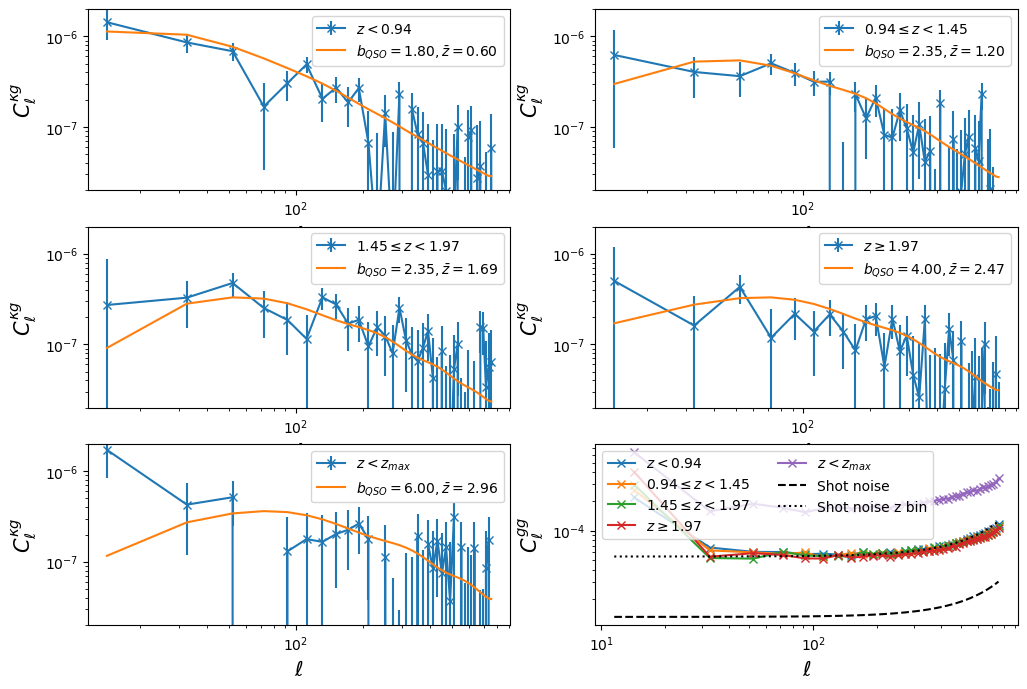

In [165]:
zlabels=['$z<%.2f$'%bounds[0],'$%.2f\leq z<%.2f$'%(bounds[0],bounds[1]),'$%.2f\leq z<%.2f$'%(bounds[1],bounds[2]),
'$z\geq %.2f$'%bounds[-1],'$z<z_{max}$']

plotid=320
bias_rescaling=[1.8/b_quasar,2.35/b_quasar,2.35/b_quasar,4./b_quasar,6./b_quasar]
median_z = [np.mean(zcat[mask_z1]),np.mean(zcat[mask_z2]),np.mean(zcat[mask_z3]),
            np.mean(zcat[mask_z4]),np.mean(zcat[mask_z5])]

pl.figure(figsize=(12,8))

for i,clkg_czi in enumerate(clkg_cz[:-1]):
    pl.subplot(int(plotid+i+1))
    #errorbar
    dki_z1 = np.sqrt(clkk_cz*clgg_cz[i] + clkg_czi**2)/np.sqrt((2*lb+1)*delta_b*np.mean(apomask_gal50))
    pl.errorbar(lb,clkg_czi,yerr=dki_z1,ls='-',marker='x',label=zlabels[i])
    pl.errorbar(lb,bias_rescaling[i]*cl_kg_thcz_binned[i],ls='-',
                marker='',label='$b_{QSO}=%.2f, \\bar{z}=%.2f$'%(b_quasar*bias_rescaling[i],median_z[i]))
    pl.ylim(2e-08,2e-06)
    pl.legend()
    pl.xscale('log')
    pl.yscale('log')    
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C^{\kappa g}_\ell$',size=15)
#pl.show()

pl.subplot(326)
for i,clgg_czi in enumerate(clgg_cz[:-1]):
    pl.errorbar(lb,clgg_czi,ls='-',marker='x',label=zlabels[i])

#pl.errorbar(lb,cl_gg_th_binned,color='black')
pl.errorbar(lb_spice,shot_noise,ls='--',color='black',label='Shot noise')
pl.errorbar(lb_spice,shot_noise*nbar/nbar_z1,ls=':',color='black',label='Shot noise z bin')

pl.xlabel('$\ell$',size=15)
pl.ylabel('$C^{gg}_\ell$',size=15)
pl.legend(loc='best',ncol=2)
pl.xscale('log')
pl.yscale('log')
pl.show()

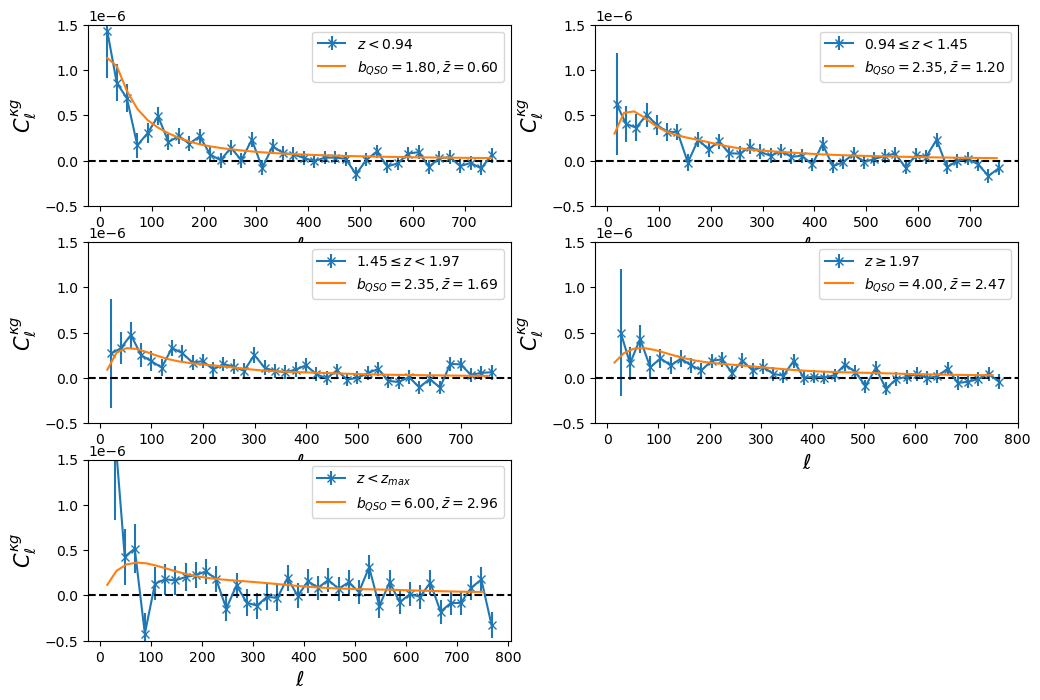

In [168]:
zlabels=['$z<%.2f$'%bounds[0],'$%.2f\leq z<%.2f$'%(bounds[0],bounds[1]),'$%.2f\leq z<%.2f$'%(bounds[1],bounds[2]),
'$z\geq %.2f$'%bounds[-1],'$z<z_{max}$']

plotid=320
bias_rescaling=[1.8/b_quasar,2.35/b_quasar,2.35/b_quasar,4./b_quasar,6./b_quasar]
median_z = [np.mean(zcat[mask_z1]),np.mean(zcat[mask_z2]),np.mean(zcat[mask_z3]),
            np.mean(zcat[mask_z4]),np.mean(zcat[mask_z5])]

pl.figure(figsize=(12,8))

for i,clkg_czi in enumerate(clkg_cz[:-1]):
    pl.subplot(int(plotid+i+1))
    #errorbar
    dki_z1 = np.sqrt(clkk_cz*clgg_cz[i] + clkg_czi**2)/np.sqrt((2*lb+1)*delta_b*np.mean(apomask_gal50))
    pl.errorbar(lb+4*i,clkg_czi,yerr=dki_z1,ls='-',marker='x',label=zlabels[i])
    pl.errorbar(lb,bias_rescaling[i]*cl_kg_thcz_binned[i],ls='-',
                marker='',label='$b_{QSO}=%.2f, \\bar{z}=%.2f$'%(b_quasar*bias_rescaling[i],median_z[i]))
    pl.axhline(0,color='black',ls='--')
    #pl.errorbar(lb,cl_kg_thcz_binned[i],ls='-',marker='')
#pl.errorbar(lb,clgg_cz[-1],ls='-',marker='x',label=zlabels[i])
#pl.errorbar(lb,cl_kg_th_binned,color='black')
    pl.ylim(-0.5e-06,1.5e-06)
    pl.legend()
    #pl.xscale('log')
    #pl.yscale('log')    
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C^{\kappa g}_\ell$',size=15)
pl.show()

# Jackknife covariance

Here we try to do a jackknife covariance estimation and compare with the analytical error bars based on the $f_{sky}$ approximation this shoud include only the Gaussian sample variance while we can test the correlation between bins.

We define a patch of the sky corresponding on the visible pixel once the galaxy is masked at nside=8. For each of those low resolution pixels we remove the corresponding patch of the sky multiplying the pixel mask by the galactic mask and compute the power spectra. Then the covariance can be estimated as

$$ Cov(C_\ell^{AB},C_{\ell^\prime}^{AB}) = \frac{N_{patches} -1}{N_{patches}}\sum_{i=0}^{N_{patches}} (C^{AB}_\ell - \bar{C}^{AB}_{\ell})_i(C^{AB}_{\ell^\prime} - \bar{C}^{AB}_{\ell^\prime})_i$$

where in each i-th realization we have removed the i-th low resolution pixel. $\bar{C}^{AB}_{\ell}=\sum_{i=0}^{N_{patches}} \left(C_\ell^{AB}\right)_i$ 

is the power spectrum averaged over the patches. 
We compare the diagonal of the covariance matrix to the analytical formula for a Gaussian random field

$$ Cov^{Gauss}(C_\ell^{AB},C_{\ell^\prime}^{AB}) = \frac{\delta_{\ell\ell^\prime}}{(2\ell_1)\Delta\ell f_{sky}} (C^{AA}_\ell C^{BB}_{\ell^\prime} +C^{AB}_\ell C^{AB}_{\ell^\prime})$$

In [392]:
try:
    clkk_cz_jk =np.load('../../clkk_cov.npy')
    clkg_cz_jk =np.load('../../clkg_cov.npy')
    clgg_cz_jk =np.load('../../clgg_cov.npy')
except:
    clkk_cz_jk =[] 
    clkg_cz_jk =[] 
    clgg_cz_jk =[] 
    nside_jk=8
    galmask50_jk = hp.ud_grade(galmask50_lr,nside_out=nside_jk)
    pixlist_jk = np.where(galmask50_jk>0.5)[0]
    print(len(pixlist_jk))
    mask_jklr = np.ones(hp.nside2npix(nside_jk))
    for p in pixlist_jk:
        mask_jklr[p]=0.
        mask_pixel= hp.ud_grade(mask_jklr,nside_out=nside)
        mask_jklr[p]=1.
        jkmask = apomask_gal50*mask_pixel
        f0 = nmt.NmtField(jkmask, [klr],beam=beam) # corrects for pixel window as klr computed from downgrade
        if True:#p==pixlist_jk[0]:
            w = nmt.NmtWorkspace()
            w.compute_coupling_matrix(f0, f0, b)
        
        clkk_cz_jk.append(compute_master(f0,f0,w)[0])
        clkg_cz_buf=[]
        clgg_cz_buf=[]
        
        for i,cmap in enumerate([cz1,cz2,cz3,cz4,cz5,c]):
            fcz = nmt.NmtField(jkmask, [cmap-cmap[apomask_gal50>0].mean()],beam=beam) # corrects for pixel window as klr computed from downgrade
        
            clkg_cz_buf.append( compute_master(f0,fcz,w)[0])
            clgg_cz_buf.append( compute_master(fcz,fcz,w)[0])
        
        clkg_cz_jk.append(clkg_cz_buf) 
        clgg_cz_jk.append(clgg_cz_buf)
    clkk_cz_jk=np.array(clkk_cz_jk)
    clkg_cz_jk=np.array(clkg_cz_jk)
    clgg_cz_jk=np.array(clgg_cz_jk)
    np.save('../../clkk_cov.npy',clkk_cz_jk)
    np.save('../../clkg_cov.npy',clkg_cz_jk)
    np.save('../../clgg_cov.npy',clgg_cz_jk)        

381


In [421]:
npatches = clkk_cz_jk.shape[0]
norm = npatches -1
clkk_cov = norm*np.cov(clkk_cz_jk,rowvar=False,bias=True) # bias = True normalizes by N and not by N-1
clkg_cov = [norm*np.cov(clkg_cz_jk[:,i,:],rowvar=False,bias=True) for i in range(6)]
clgg_cov = [norm*np.cov(clgg_cz_jk[:,i,:],rowvar=False,bias=True) for i in range(6)]

clkk_corr = np.corrcoef(clkk_cz_jk,rowvar=False) # bias = True normalizes by N and not by N-1
clkg_corr = [np.corrcoef(clkg_cz_jk[:,i,:],rowvar=False) for i in range(6)]
clgg_corr = [np.corrcoef(clgg_cz_jk[:,i,:],rowvar=False) for i in range(6)]


### Correlation

For the cross-correlation all bins seems to be pretty uncorrelated, the maximum correlation is 20% in the first 2 neighbouring bins. This holds for all samples and sub-samples. Similar conclusions apply to the galaxy auto spectrum. The CMB lensing has stronger correlations in the highest multipoles due to correlated noise in the map. 

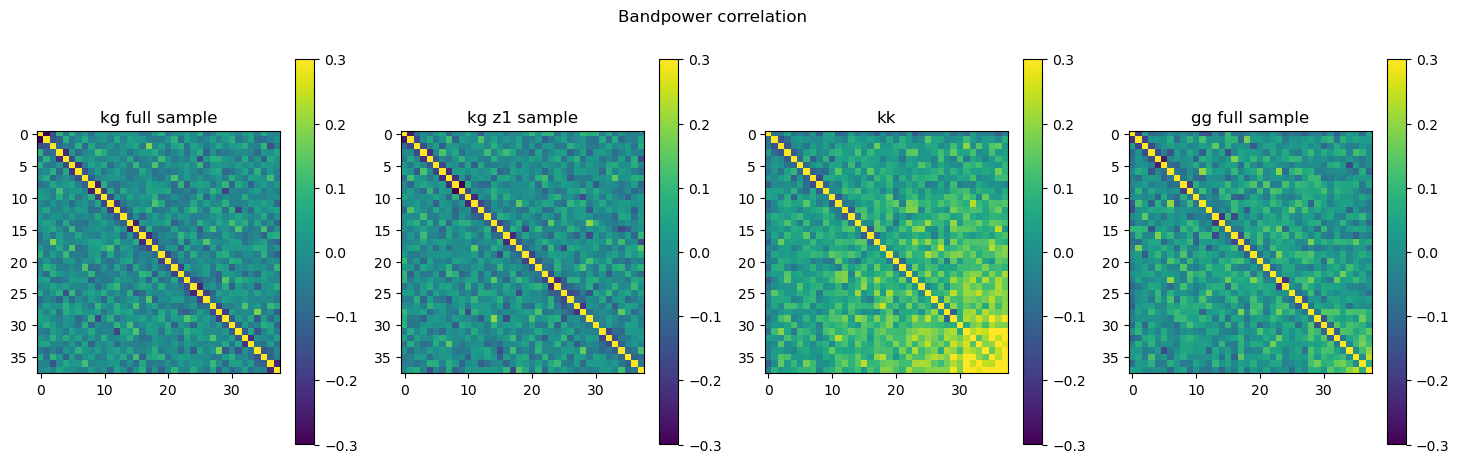

In [459]:
pl.figure(figsize=(18,5))
pl.subplot(141)
pl.imshow(clkg_corr[-1],vmin=-0.3,vmax=0.3)
pl.title("kg full sample")
pl.colorbar()
pl.subplot(142)
pl.imshow(clkg_corr[0],vmin=-0.3,vmax=0.3)
pl.title("kg z1 sample")
pl.colorbar()
pl.subplot(143)
pl.imshow(clkk_corr,vmin=-0.3,vmax=0.3)
pl.title("kk")
pl.colorbar()
pl.subplot(144)
pl.imshow(clgg_corr[0],vmin=-0.3,vmax=0.3)
pl.title("gg full sample")
pl.colorbar()
pl.suptitle("Bandpower correlation")
pl.show()

### Covariance and errors

There seem to be an offset of $f_{sky}$ in the jackknife covariance that is indipendent of the multipole we are looking at.  If I muliply the Jackknife-estimated covariance by $f_{sky}$, the agreement with the analytical formula is very good. 

The analytical formula should be accurate but if the jackknife is correct it means we are under estimating the number of degrees of freedom with the Gaussian approximation that I have adopted so far. This should decrease the signfiicance by ~1.3 and move the detection significance to something close to 12 from 18. 

The fact that $\chi^2$ test gives numbers close to 1 does not seem to indicate a massive underestimation of the error bars. TBD.

0.4780234059152703 0.47718829979271676 20


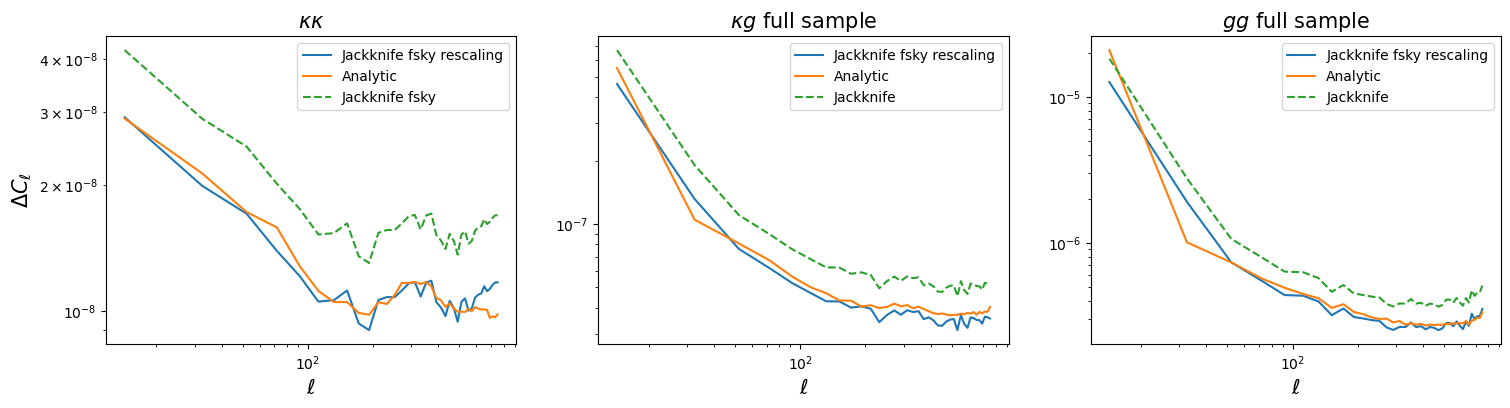

In [435]:

fsky = np.mean(analysis_mask)
fsky_eff = np.mean(analysis_mask**2)**2/np.mean(analysis_mask**4) # better approximation that accounts for 
#print(fsky,fsky_eff,delta_b)
#print(npatches*3/5.)
#print(fsky)
dof = (2*lb+1)*delta_b*fsky_eff
pl.figure(figsize=(18,4))
pl.subplot(131)
pl.loglog(lb,np.sqrt(clkk_cov.diagonal()*fsky_eff),label='Jackknife fsky rescaling')
pl.loglog(lb,np.sqrt(2*clkk**2/dof),label='Analytic')
pl.loglog(lb,np.std(clkk_cz_jk,axis=0,ddof=0)*np.sqrt(npatches-1),ls='--',label='Jackknife fsky')
pl.xlabel("$\ell$",size=15)
pl.ylabel("$\Delta C_\ell$",size=15)
pl.title("$\kappa\kappa$",size=15)
pl.legend()
#pl.show()

pl.subplot(132)
pl.loglog(lb,np.sqrt(clkg_cov[-1].diagonal()*fsky_eff),label='Jackknife fsky rescaling')
pl.loglog(lb,dkg,label='Analytic')
pl.loglog(lb,np.sqrt(clkg_cov[-1].diagonal()),ls='--',label='Jackknife')
pl.xlabel("$\ell$",size=15)
pl.title("$\kappa g$ full sample",size=15)
pl.legend()
#pl.show()

pl.subplot(133)
pl.loglog(lb,np.sqrt(clgg_cov[-1].diagonal()*fsky_eff),label='Jackknife fsky rescaling')
pl.loglog(lb,(np.sqrt(2/dof)*clgg),label='Analytic')
pl.loglog(lb,np.sqrt(clgg_cov[-1].diagonal()),ls='--',label='Jackknife')
pl.xlabel("$\ell$",size=15)
pl.title("$gg$ full sample",size=15)
pl.legend()
pl.show()






# SPT-SZ results


### SPT-SZ data 

Prepares masks and data of the SPT-SZ survey converting $a_{\ell m}$  and masks from Celestial to Galactic coordinates. Then filter out scales smaller than those supported by the HEALPix grid.  

In [201]:
try:
    spt_klmlr_g = hp.read_alm('../../spt_klm_lr_g.fits')
    spt_klm_g=hp.read_alm('/Users/gfabbian/Work/SPT/kcmb_S0a_S0a_baseline_mcrlpp2d_Ldiv20_full_Lmin30.alm_Galcoord.txt')        
    masklr_spt = hp.read_map('../../spt_bdry_lr_g.fits')
    masklr_spt_c = hp.read_map('../../spt_bdry_lr_c.fits')
except:
    print("Process SPT data")
    spt_klm_c = hp.read_alm('/Users/gfabbian/Work/SPT/kcmb_S0a_S0a_baseline_mcrlpp2d_Ldiv20_full_Lmin30.alm.txt')
    spt_klm_g=rot.rotate_alm(spt_klm_c)    
    hp.write_alm('/Users/gfabbian/Work/SPT/kcmb_S0a_S0a_baseline_mcrlpp2d_Ldiv20_full_Lmin30.alm_Galcoord.txt',spt_klm_g)        
    #spt_klm_g=hp.read_alm('/Users/gfabbian/Work/SPT/kcmb_S0a_S0a_baseline_mcrlpp2d_Ldiv20_full_Lmin30.alm_Galcoord.txt')            
    # write boundary mask at low resolution
    masklr_spt_c = hp.ud_grade(hp.read_map('/Users/gfabbian/Work/SPT/mask_nside8192_bdry.fits'),nside_out=nside)
    masklr_spt_c[masklr_spt_c>0]=1.
    hp.write_map('../../spt_bdry_lr_c.fits',masklr_spt_c,overwrite=True)
    
    # convert to galactic coordinates
    masklr_spt = rot.rotate_map_pixel(masklr_spt_c)
    masklr_spt[masklr_spt>0]=1.
    hp.write_map('../../spt_bdry_lr_g.fits',masklr_spt,overwrite=True)
    #masklr_spt = hp.read_map('../../spt_bdry_lr_g.fits') 

# filters out modes above the sampling of healpix
fl_spt = np.ones(3001)
fl_spt[:3*nside] = hp.pixwin(nside,lmax=3*nside-1)
fl_spt[3*nside:]=0.
spt_klmlr_g = hp.almxfl(spt_klm_g,fl_spt)
hp.write_alm('../../spt_klm_lr_g.fits',spt_klmlr_g,overwrite=True)    
    

Computes map and apodize mask

In [202]:
spt_klr = hp.alm2map(spt_klmlr_g,nside=nside,lmax=3000,pol=False) 
apomask_spt = nmt.mask_apodization(masklr_spt,1, apotype="C2")

### Power spectrum computation.

Here we redefine the binning so that the first bin is extended to include all the modes that have been filtered out by SPT-SZ and the second is reduced so that the following ones follow the same binning of Planck. Here we assume the the same binning adopted by Planck but we should probably optimize as the correlation of the bins is larger due to the smaller sky fraction observed by SPT.

Potentialy we could do maps at nside=512 and push the smaller scales a little futher. 

In [273]:
delta_b=20
ivar_weighting_binning=True
if ivar_weighting_binning:
    ells = np.arange(3 * nside, dtype='int32')
    weights = 2*ells+1.
    bpws_spt = -1 + np.zeros_like(ells)  # Array of bandpower indices
    i = 0
    while delta_b * (i + 1) + 2 < 3 * nside:
        bpws_spt[delta_b * i + 2:delta_b * (i + 1) + 2] = i
        i += 1
    bpws_spt[2:30] = 0.
    bpws_spt[30:b.get_ell_max(1)+1] = 1
    b_spt = nmt.NmtBin(nside=nside, bpws=bpws_spt, ells=ells, weights=weights)
else:
    b = nmt.NmtBin.from_nside_linear(nside, delta_b,is_Dell=False)
    b_ini_spt = list([b.get_ell_min(i) for i in range(len(lb))])
    b_end_spt = list([b.get_ell_max(i)+1 for i in range(len(lb))])
    b_end_spt[0]=30
    b_ini_spt[1]=30
    b_spt = nmt.NmtBin.from_edges(b_ini_spt, b_end_spt,is_Dell=False)
    
lb_spt = b_spt.get_effective_ells()

f0 = nmt.NmtField(apomask_spt, [spt_klr],beam=beam) # corrects for pixel window as klr computed from downgrade

w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f0, f0, b_spt)

clkk_cz_spt = compute_master(f0,f0,w)[0]


f0 = nmt.NmtField(apomask_spt, [klr],beam=beam) # corrects for pixel window as klr computed from downgrade
clkk_planck_spt = compute_master(f0,f0,w)[0]

clkg_cz_spt=[]
clgg_cz_spt=[]
cl_gg_thcz_spt_binned = []
cl_kg_thcz_spt_binned = []


for i,cmap in enumerate([cz1,cz2,cz3,cz4,cz5,c]):
    fcz = nmt.NmtField(apomask_spt, [cmap-0*cmap[apomask_spt>0].mean()],beam=beam) # corrects for pixel window as klr computed from downgrade

    clkg_cz_spt.append( compute_master(f0,fcz,w)[0])
    clgg_cz_spt.append( compute_master(fcz,fcz,w)[0])
    
    cl_gg_thcz_spt_binned.append(w.decouple_cell(w.couple_cell([clgg_th_z[i]]))[0])
    cl_kg_thcz_spt_binned.append(w.decouple_cell(w.couple_cell([clkg_th_z[i]]))[0])    

### Results

The data are in quite good agreement with the results derived for Planck. Given the reduced overlap we can consider the patches to be basically independent and thus the measurments should be within $\sim 2\sigma$. The first two bins show some differences as the majority of the scales in this range was filtered in SPT. 

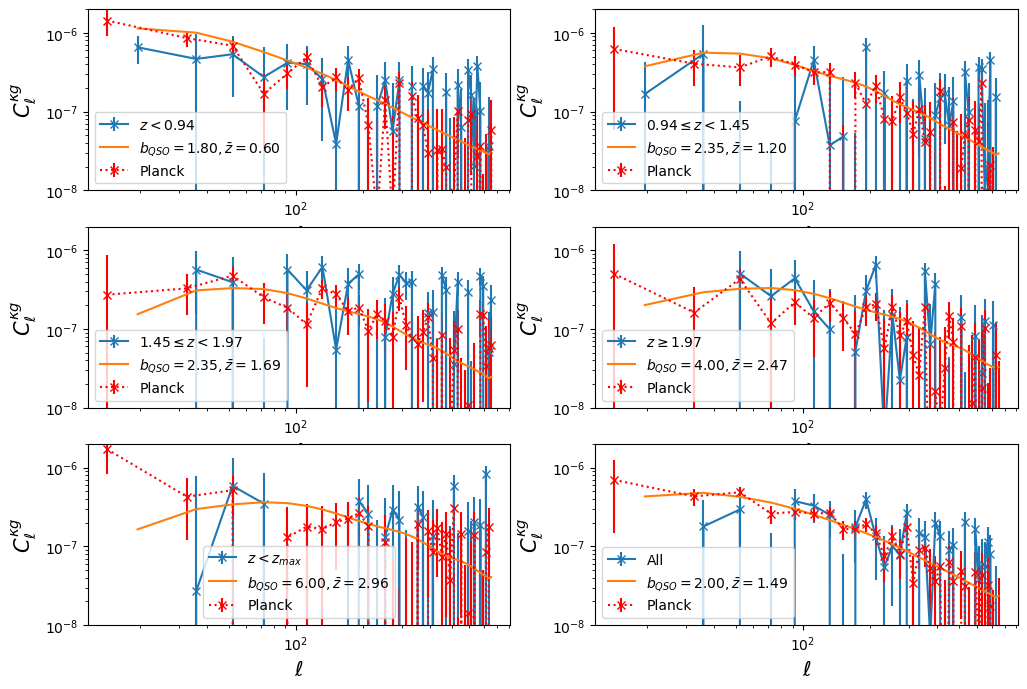

In [274]:
zlabels=['$z<%.2f$'%bounds[0],'$%.2f\leq z<%.2f$'%(bounds[0],bounds[1]),'$%.2f\leq z<%.2f$'%(bounds[1],bounds[2]),
'$z\geq %.2f$'%bounds[-1],'$z<z_{max}$','All']

plotid=320
bias_rescaling=[1.8/b_quasar,2.35/b_quasar,2.35/b_quasar,4./b_quasar,6./b_quasar,1.]
median_z = [np.mean(zcat[mask_z1]),np.mean(zcat[mask_z2]),np.mean(zcat[mask_z3]),
            np.mean(zcat[mask_z4]),np.mean(zcat[mask_z5]),np.mean(zcat)]

pl.figure(figsize=(12,8))

for i,clkg_czi in enumerate(clkg_cz_spt):
    pl.subplot(int(plotid+i+1))
    #errorbar
    dkg_z1 = np.sqrt(np.abs(clkk_cz_spt*clgg_cz_spt[i]) + clkg_czi**2)/np.sqrt((2*lb_spt+1)*
                    b_spt.get_nell_list()*np.mean(apomask_spt))
    pl.errorbar(lb_spt,clkg_czi,yerr=dkg_z1,ls='-',marker='x',label=zlabels[i])
    pl.errorbar(lb_spt,bias_rescaling[i]*cl_kg_thcz_spt_binned[i],ls='-',
                marker='',label='$b_{QSO}=%.2f, \\bar{z}=%.2f$'%(b_quasar*bias_rescaling[i],median_z[i]))
    dkg_planck = np.sqrt(clkk*clgg_cz[i] + clkg_cz[i]**2)/np.sqrt((2*lb+1)*b.get_nell_list()*np.mean(analysis_mask))
    pl.errorbar(lb,clkg_cz[i],dkg_planck,ls=':',marker='x',color='red',label='Planck')       
    pl.legend()
    pl.xscale('log')
    pl.yscale('log')    
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C^{\kappa g}_\ell$',size=15)
    pl.ylim(1e-08,2e-06)
pl.show()

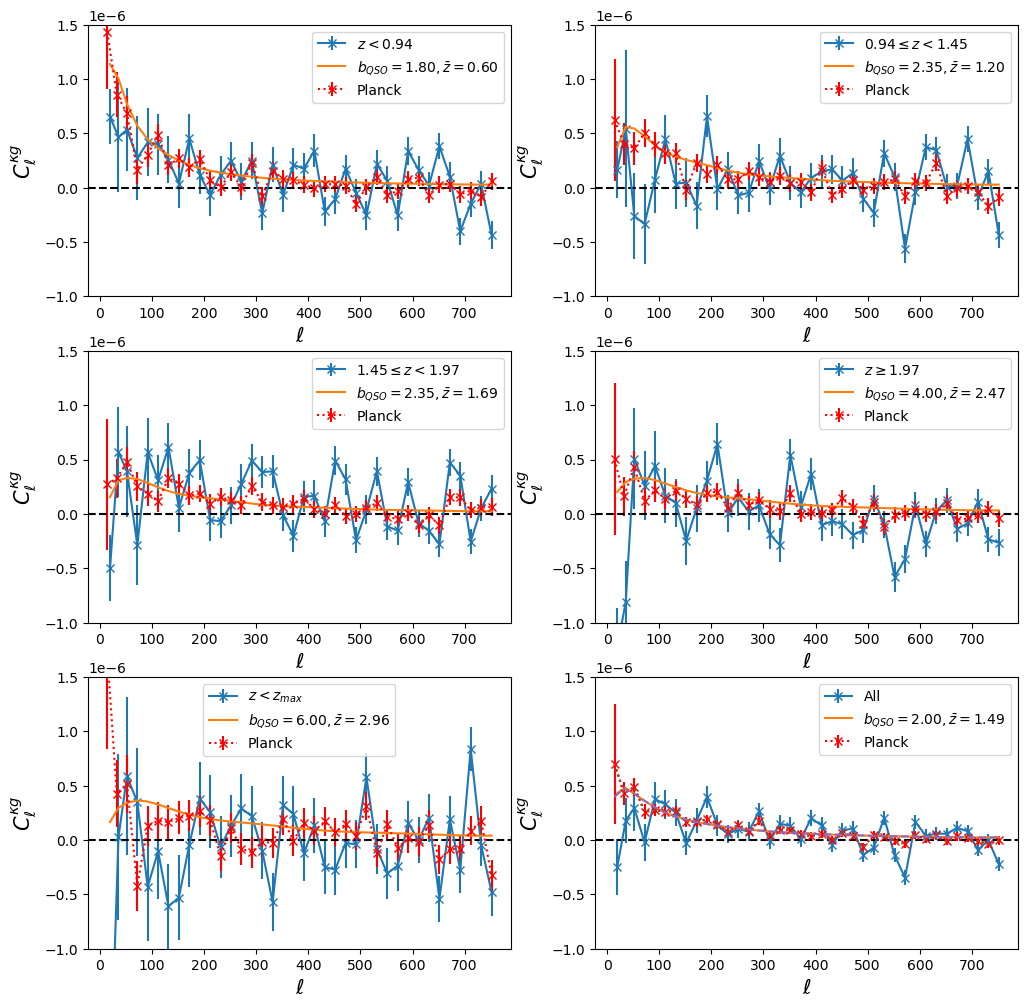

In [275]:
pl.figure(figsize=(12,12))

for i,clkg_czi in enumerate(clkg_cz_spt):
    pl.subplot(int(plotid+i+1))
    #errorbar
    dkg_z1 = np.sqrt(np.abs(clkk_cz_spt*clgg_cz_spt[i]) + clkg_czi**2)/np.sqrt((2*lb_spt+1)*
                    b_spt.get_nell_list()*np.mean(apomask_spt))
    pl.errorbar(lb_spt,clkg_czi,yerr=dkg_z1,ls='-',marker='x',label=zlabels[i])
    pl.errorbar(lb_spt,bias_rescaling[i]*cl_kg_thcz_spt_binned[i],ls='-',
                marker='',label='$b_{QSO}=%.2f, \\bar{z}=%.2f$'%(b_quasar*bias_rescaling[i],median_z[i]))
    dkg_planck = np.sqrt(clkk*clgg_cz[i] + clkg_cz[i]**2)/np.sqrt((2*lb+1)*b.get_nell_list()*np.mean(analysis_mask))
    pl.errorbar(lb,clkg_cz[i],dkg_planck,ls=':',marker='x',color='red',label='Planck')           
    pl.legend()
    pl.axhline(0,color='black',ls='--')
    #pl.xscale('log')
    #pl.yscale('log')    
    pl.xlabel('$\ell$',size=15)
    pl.ylabel('$C^{\kappa g}_\ell$',size=15)
    pl.ylim(-1e-06,1.5e-06)
pl.errorbar(lb,clkg_cz[-1],ls=':')    
pl.errorbar(lb,clkg,ls=':')    
pl.errorbar(lb,cl_kg_thcz_binned[-1],ls='--')
pl.show()

### Planck vs SPT sensitivity comparison

Below we compare the CMB lensing noise and the error bar of the cross-correlation spectrum between the full sample and CMB lensing of Planck and SPT-SZ. Despite the lensing noise is significantly lower at small angular scales, the final error bar for SPT is too much higher than the Planck results given that the sky area covered by SPTpol is much lower (~5% vs ~50%). The loss of sky fraction compensates any gain in terms of noise. This is expected since the dominating component of the error bars is the one due to the galaxy clustering. 

Note that we expluded the first bin as the SPT-SZ lensing map have been filtered and do not contain power at $\ell<30$. The second bin has also a different width for SPT-SZ. 

We could probably improve somewhat the noise going at $\ell>>1000$ but the shot noise of the galaxy would potentially increase even more so the gain is unclear. 

/var/folders/3c/k4c228y17_b7sq_m4m7gy8w80000gq/T/ipykernel_8868/2259799382.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  pl.ylim(-1e-06,7e-06)


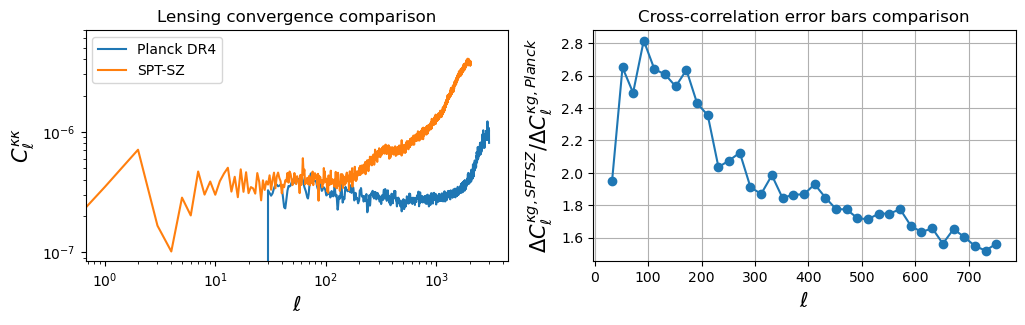

In [276]:
pl.figure(figsize=(12,3))
pl.subplot(121)
pl.loglog(hp.alm2cl(hp.read_alm(
    '/Users/gfabbian/Work/SPT/kcmb_S0a_S0a_baseline_mcrlpp2d_Ldiv20_full_Lmin30.alm_Galcoord.txt'))/np.mean(
    apomask_spt),label='Planck DR4')
pl.loglog(hp.alm2cl(klm)/np.mean(lensmask),label='SPT-SZ')
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C^{\kappa \kappa}_\ell$',size=15)
pl.ylim(-1e-06,7e-06)
pl.title("Lensing convergence comparison")
pl.legend()
pl.subplot(122)
ratio = dkg_z1/dkg
pl.plot(lb[1:],ratio[1:],marker='o')
pl.xlabel('$\ell$',size=15)
pl.ylabel('$\Delta C^{\kappa g,SPTSZ}_\ell/\Delta C^{\kappa g,Planck}_\ell$',size=15)
pl.title("Cross-correlation error bars comparison")
pl.grid()
pl.show()